In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install -U scikit-learn

!pip install contractions
!pip install nltk
!pip install nlpaug
!pip install numpy git+https://github.com/makcedward/nlpaug.git

!pip install transformers datasets evaluate accelerate peft
!pip install transformers
!pip install peft
!pip install git+https://github.com/huggingface/peft

  Cloning https://github.com/makcedward/nlpaug.git to /tmp/pip-req-build-kihrqnio
  Running command git clone --filter=blob:none --quiet https://github.com/makcedward/nlpaug.git /tmp/pip-req-build-kihrqnio
  Resolved https://github.com/makcedward/nlpaug.git to commit 23800cbb9632c7fc8c4a88d46f9c4ecf68a96299
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/huggingface/peft to /tmp/pip-req-build-f5i7hrdb
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/peft /tmp/pip-req-build-f5i7hrdb
  Resolved https://github.com/huggingface/peft to commit 8e979fc73248ccb4c5b5a99c415f3e14a37daae6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import contractions
import nltk
import nlpaug
import transformers
import peft
from peft import LoraConfig, get_peft_model
from datasets import load_dataset

In [3]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

# 1. Model

In [4]:
model_name = "FacebookAI/xlm-roberta-large"

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
peft_config = LoraConfig(task_type="SEQ_CLS", inference_mode=False, r=15, lora_alpha=20, lora_dropout=0.1)
peft_model = get_peft_model(model, peft_config)

In [7]:
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): XLMRobertaForSequenceClassification(
      (roberta): XLMRobertaModel(
        (embeddings): XLMRobertaEmbeddings(
          (word_embeddings): Embedding(250002, 1024, padding_idx=1)
          (position_embeddings): Embedding(514, 1024, padding_idx=1)
          (token_type_embeddings): Embedding(1, 1024)
          (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): XLMRobertaEncoder(
          (layer): ModuleList(
            (0-23): 24 x XLMRobertaLayer(
              (attention): XLMRobertaAttention(
                (self): XLMRobertaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
         

# 2. Data

In [8]:
data_files = {
        "train": "data/noIndex_train.csv", 
        "test": "data/noIndex_val.csv"
}

In [9]:
from datasets import load_dataset
dataset = load_dataset("csv", data_files=data_files)
dataset = dataset.rename_column("stars", "label")

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 37800
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 600
    })
})

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(data):
    return tokenizer(data['text'], truncation=True, padding=True)

def map_labels(label):
    return label - 1

In [12]:
tokenized_dataset = dataset.map(tokenize_fn, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.map(lambda example: {'label': map_labels(example['label'])})

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

In [13]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 37800
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 600
    })
})

In [14]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 3. Metrics

In [15]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

In [16]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# 4. LoRa Training

In [17]:
peft_model.print_trainable_parameters()

trainable params: 2,527,235 || all params: 562,420,742 || trainable%: 0.4493495369699576


In [21]:
from transformers import TrainingArguments, Trainer

lora_training_args = TrainingArguments(
    output_dir="LoRa_RoBERTa",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=250, 
    load_best_model_at_end=True,
    save_total_limit=1,  # Limit the total number of saved checkpoints
    eval_steps=250,  # Number of evaluation steps,
    lr_scheduler_type="linear",
    seed=42
)

In [22]:
lora_trainer = Trainer(
    model=peft_model,
    args=lora_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [23]:
lora_trainer.train()
lora_trainer.evaluate()

Step,Training Loss,Validation Loss,Accuracy
250,No log,1.000489,0.493333
500,0.993700,0.737030,0.688333
750,0.993700,0.755233,0.671667
1000,0.763600,0.725977,0.685000
1250,0.763600,0.693715,0.711667
1500,0.730700,0.683430,0.701667
1750,0.730700,0.701310,0.701667
2000,0.707300,0.681410,0.701667
2250,0.707300,0.699144,0.693333
2500,0.692200,0.663807,0.721667


{'eval_loss': 0.6555784940719604,
 'eval_accuracy': 0.7233333333333334,
 'eval_runtime': 11.9382,
 'eval_samples_per_second': 50.259,
 'eval_steps_per_second': 3.183,
 'epoch': 2.0}

# 5. Inference to a CSV file

In [25]:
inference_dataset = load_dataset("csv", data_files="data/test.csv")

In [26]:
def tokenize_inference(example):
    tokenized_text = tokenizer(example['text'], truncation=True, padding=True, return_tensors="pt")
    output = peft_model(input_ids=tokenized_text["input_ids"].to("cuda"), attention_mask=tokenized_text["attention_mask"].to("cuda"))
    pred = output.logits.argmax(dim=-1).item()
    return {"label": pred+1}

In [27]:
tokenized_inference_dataset = inference_dataset.map(tokenize_inference)

Map:   0%|          | 0/1801 [00:00<?, ? examples/s]

In [28]:
tokenized_inference_dataset

DatasetDict({
    train: Dataset({
        features: ['ID', 'text', 'label'],
        num_rows: 1801
    })
})

In [29]:
tokenized_inference_dataset = tokenized_inference_dataset.remove_columns(["text"])
tokenized_inference_dataset["train"].to_csv("predictions.csv", index=False)

Creating CSV from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

11509

# 6. Analyzing the Results

In [30]:
dataset = load_dataset("csv", data_files="data/train.csv")

Generating train split: 0 examples [00:00, ? examples/s]

In [31]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'stars'],
        num_rows: 6000
    })
})

In [40]:
def prob_inference(example):
    tokenized_text = tokenizer(example['text'], truncation=True, padding=True, return_tensors="pt")
    output = peft_model(input_ids=tokenized_text["input_ids"].to("cuda"), attention_mask=tokenized_text["attention_mask"].to("cuda"))
    pred = output.logits.argmax(dim=-1).item()
    probabilities = torch.nn.functional.softmax(output.logits, dim=-1).squeeze().tolist()
    return {"label": pred+1, 
        "prob_0": probabilities[0], 
        "prob_1": probabilities[1],
        "prob_2": probabilities[2]
           }

In [41]:
dataset = dataset.map(prob_inference)

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [42]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'stars', 'label', 'probabilities', 'prob_0', 'prob_1', 'prob_2'],
        num_rows: 6000
    })
})

In [46]:
dataset = dataset.remove_columns(["text", "probabilities"])

In [47]:
dataset

DatasetDict({
    train: Dataset({
        features: ['stars', 'label', 'prob_0', 'prob_1', 'prob_2'],
        num_rows: 6000
    })
})

In [48]:
dataset["train"].to_csv("probability_training.csv", index=False)

Creating CSV from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

380232

In [51]:
from sklearn.metrics import confusion_matrix

In [52]:
dataset = pd.read_csv("probability_training.csv")
print(confusion_matrix(dataset["stars"], dataset["label"]))

[[1672  307   21]
 [ 450 1235  315]
 [  88  363 1549]]


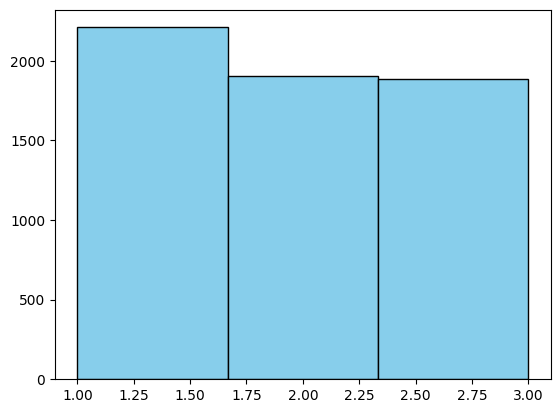

In [53]:
plt.hist(dataset["label"], bins=3, color='skyblue', edgecolor='black')
plt.show()